# Day 3 Exercises (Pandas + Seaborn)

In this set of exercises, you will perfrom part of the analysis from [Widge et al. (2019)](https://www.nature.com/articles/s41467-019-09557-4), *Deep brain stimulation of the internal capsule enhances human cognitive control and prefrontal cortex function*. In this paper, the authors found that deep brain stimulation (DBS) of the ventral striatum improved performance on a task of cognitive flexibility in a sample of 14 patients with severe depression. Specifically, response times on the task decreased (speeded up) with their DBS devices turned on.

To recreate some of the analyses and figures, you will use Pandas, Seaborn, and SciPy.stats. 

### Methods
To probe cognitive flexibility, the authors employed a modified version of the Multi-Source Interference Task (MSIT). The MSIT requires subjects to identify which of a set of three numbers is different than its neighbors. Subjects must keep three fingers of their right hand positioned over response keys corresponding to the digits 1-3. In **Control** (non-interference) trials, the target is in the same spatial position as its corresponding response key, and the flanking digits are not valid responses (i.e., they are 0s). In **Interference trials**, the target is out-of-position relative to its corresponding key-press and is flanked by other viable targets. 

Each block of trials contained 72 Control and 72 Interference trials. To prevent response sets or habituation, trial sequence in each block was pseudo-randomized so that subjects never had more than two trials in a row that shared the same interference level or desired response finger. This highly interleaved trial design was expected to place greater demands on cognitive control systems by reducing predictability of the stimuli. 

Patients performed this task twice: first with their DBS device turned **ON**, and then with their DBS device turned **OFF**.

### Data

The file *dbs.csv* contains the raw behavioral data from the 14 patients. The data is organized into six columns:

- *Subject:* the unique subject identifier.
- *Trial:* the trial number per block.
- *DBS:* the status of the DBS device (ON = 1, OFF = 0)
- *Interference:* the type of trial (Control = 0, Interference = 1)
- *Accuracy:* the accuracy of the response of the trial (Correct = 1, Incorrect = 0)
- *RT:* the response time on that trial (in seconds).

## Section 1: Preprocessing

a) Read in the DataFrame from the CSV file, *dbs.csv*.

In [1]:
import numpy as np
from pandas import read_csv

## Load data from file.
data = read_csv('dbs.csv')

b) Using `DataFrame.value_counts`, confirm there are 14 patients with 288 trials each.

In [2]:
data.Subject.value_counts()

13    288
11    288
9     288
7     288
5     288
3     288
1     288
14    288
12    288
10    288
8     288
6     288
4     288
2     288
Name: Subject, dtype: int64

c) Using `DataFrame.groupby`, compute the average accuracy per participant. Should any participant be excluded (e.g. lower than 70% accuracy)?

In [3]:
## Construct groupby object.
gb = data.groupby('Subject')

## Compute accuracy.
accuracy = gb.Accuracy.mean()
print(accuracy)

Subject
1     0.993056
2     0.996528
3     0.979167
4     1.000000
5     0.979167
6     0.954861
7     0.986111
8     0.958333
9     0.843750
10    0.913194
11    0.993056
12    0.982639
13    0.972222
14    0.979167
Name: Accuracy, dtype: float64


d) Response times for trials with incorrect responses are typically biased. In other words, they tend to be systematically faster than the average response (i.e. fast error) or slower than the average response (i.e. slow errors). 

Remove all rows corresponding to trials with incorrect responses. Confirm no incorrect responses remain.

In [4]:
## Remove incorrect responses.
data = data.query('Accuracy == 1')

## Confirmation.
print(data.Accuracy.mean())

1.0


e) Similarly, participants occasionally make unrealistic fast responses (e.g. < 300 ms). These typically correspond to accidental button presses or slips of the finger.

Remove all rows corresponding to trials with response times faster than 300 ms. Confirm the mininum response time per participant is above this threshold.

In [5]:
## Remove fast responses.
data = data.query('RT > 0.3')

## Construct groupby object.
gb = data.groupby('Subject')

## Compute accuracy.
minRT = gb.RT.min()
print(minRT)

Subject
1     0.445847
2     0.456165
3     0.438395
4     0.460700
5     0.517145
6     0.671600
7     0.599500
8     0.418900
9     0.508553
10    0.451900
11    0.398594
12    0.474323
13    0.481499
14    0.499109
Name: RT, dtype: float64


f) Reaction times are typically right-skewed. That is, on average, a distribution of reaction times is asymmetric with more responses falling on the slower side.

Using `sns.FacetGrid` (or any other plotting method of your choosing), plot the RT distribution per participant. Confirm that all (or most) RT distributions are right-skewed.

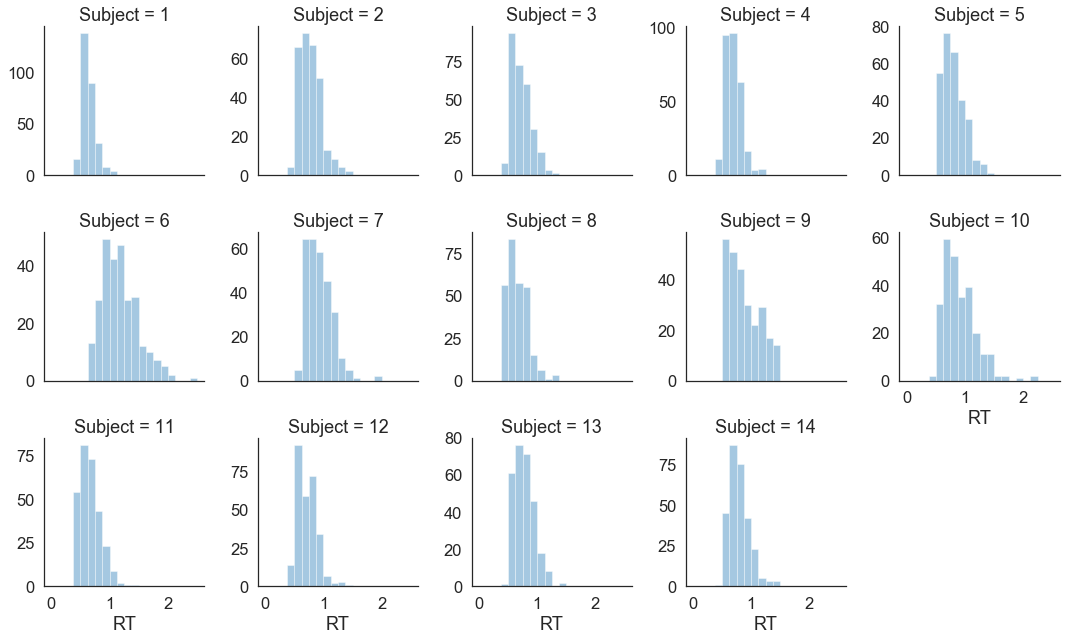

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Initialize canvas.
g = sns.FacetGrid(data, col='Subject', col_wrap=5, sharex=True, sharey=False)

## Plot histograms.
g.map(sns.distplot, 'RT', bins=np.linspace(0,2.5,21), kde=False);

g) To correct for right-skew, some analysts apply a log transform to reaction time data. 

Make a new column in the DataFrame, **logRT**, that is applying a log transform the RT data.

In [7]:
## Apply log-transform.
data['logRT'] = np.log(data['RT'])

h) Write a z-score function. The z-score is defined as:

$$ Z = \frac{X - \text{mean}(X)}{\text{sd}(X)} $$

In [8]:
def zscore(arr):
    return (arr - np.mean(arr)) / np.std(arr)

i) Apply the z-score transformation to the log reaction times (logRT) *per subject*. This has the effect of normalizing all participants' data to be in a similar range (e.g. removes baseline differences in RTs). Store the z-scored values in a new DataFrame column, **zRT**.



Hint: Remember `DataFrame.groupby` and `DataFrame.apply`.

In [9]:
## Construct groupby object.
gb = data.groupby('Subject')

## Apply z-score per subject.
data['zRT'] = gb.logRT.apply(zscore)

## Section 2: Visualization

a) Using Seaborn, visualize the difference in (z-scored) reaction times as a function of interference. Try out different plotting styles and see what you like best.

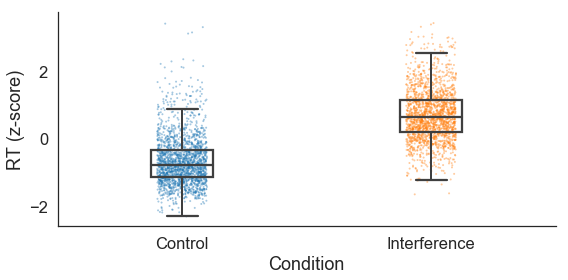

In [10]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot stripplot.
sns.stripplot('Interference', 'zRT', data=data, size=2, alpha=0.4, ax=ax)
sns.boxplot('Interference', 'zRT', data=data, zorder=10, showcaps=True,
            width=0.25, linewidth=2.25, boxprops={'facecolor':'none', "zorder":10},
            showfliers=False, whiskerprops={'linewidth':2, "zorder":10},
            saturation=1, ax=ax)

## Add info.
ax.set(xticklabels=['Control','Interference'], xlabel='Condition', ylabel='RT (z-score)')

sns.despine()
plt.tight_layout()

b) Using Seaborn, visualize the difference in (z-scored) reaction times as a function of DBS. Try out different plotting styles and see what you like best. Which contrast (interferece vs. DBS) seems to have the larger effect?

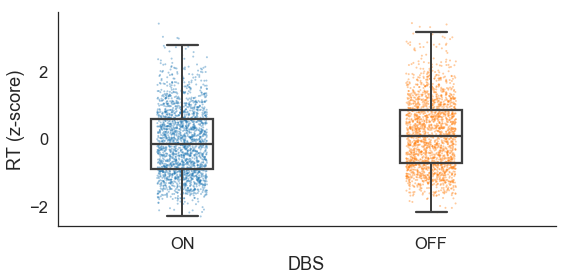

In [11]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot stripplot.
sns.stripplot('DBS', 'zRT', data=data, size=2, alpha=0.4, order=[1,0], ax=ax)
sns.boxplot('DBS', 'zRT', data=data, zorder=10, showcaps=True, order=[1,0],
            width=0.25, linewidth=2.25, boxprops={'facecolor':'none', "zorder":10},
            showfliers=False, whiskerprops={'linewidth':2, "zorder":10},
            saturation=1, ax=ax)

## Add info.
ax.set(xticklabels=['ON','OFF'], xlabel='DBS', ylabel='RT (z-score)')

sns.despine()
plt.tight_layout()

c) As an optional challenge, try to plot both contrasts (ON vs. OFF, Control vs. Intereference) simultaneously. 

Hint: Read up on the `hue` argument in Seaborn.

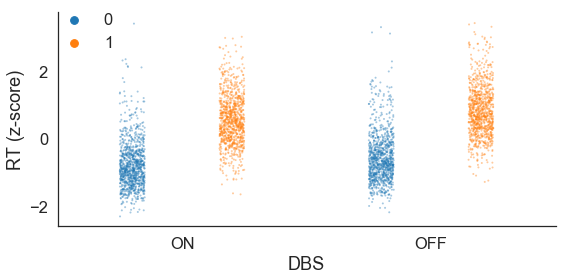

In [12]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot stripplot.
sns.stripplot('DBS', 'zRT', 'Interference', data=data, size=2, alpha=0.4, 
              order=[1,0], dodge=True, ax=ax)

## Add info.
ax.set(xticklabels=['ON','OFF'], xlabel='DBS', ylabel='RT (z-score)')
ax.legend(loc=2, frameon=False, borderpad=-0.5)

sns.despine()
plt.tight_layout()

## Section 3: Statistics

a) Use `DataFrame.groupby` to calculate the average z-scored response time difference (collapsing across patients) for both contrasts (i.e. Inteference - Control, DBS ON - DBS OFF).

In [13]:
## Contrast: Interference.
data.groupby('Interference').zRT.mean()

Interference
0   -0.665321
1    0.690155
Name: zRT, dtype: float64

In [14]:
## Contrast: DBS.
data.groupby('DBS').zRT.mean()

DBS
0    0.11856
1   -0.11724
Name: zRT, dtype: float64

b) Perform an independent samples t-test to test for significance differences in the two contrasts. Which effect is larger?

In [15]:
from scipy.stats import ttest_ind

## Contrst: Interference.
t, p = ttest_ind(data.query('Interference == 0').zRT, data.query('Interference == 1').zRT)
print('Interference: t = %0.3f, p = %0.3f' %(t,p))

## Contrst: DBS.
t, p = ttest_ind(data.query('DBS == 0').zRT, data.query('DBS == 1').zRT)
print('Interference: t = %0.3f, p = %0.3f' %(t,p))

Interference: t = -57.749, p = 0.000
Interference: t = 7.441, p = 0.000
